In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
!pip install tensorflow keras

In [31]:
df = pd.read_csv('/content/modified_exoplanet_habitability.csv')

In [32]:
df.head()

,rowid,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,cb_flag,rv_flag,pul_flag,ptv_flag,...,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,habitability
0,1,11 Com b,11 Com,2,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2,1,2,0,0,0,0,0.0
1,2,11 UMi b,11 UMi,1,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
2,3,14 And b,14 And,1,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0,0,0.0
3,4,14 Her b,14 Her,1,2,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,4,1,0,0,0,0.0
4,5,16 Cyg B b,16 Cyg B,3,1,0,0,1,0,0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5,1,4,3,0,0,0,0.0


In [33]:
earth_data = {
    'pl_name': 'Earth', 'pl_rade': 1.00, 'pl_bmasse': 1.00, 'pl_dens': 5.51,
    'pl_eqt': 255, 'pl_orbper': 365.25, 'pl_orbsmax': 1.0, 'st_lum': 0.0
}

In [34]:
if 'Earth' not in df['pl_name'].values:
    df = pd.concat([pd.DataFrame([earth_data]), df], ignore_index=True)

print("--- 1. Using Your Data (with Earth added) ---")
print(df.head())

--- 1. Using Your Data (with Earth added) ---
    pl_name  pl_rade    pl_bmasse  pl_dens  pl_eqt   pl_orbper  pl_orbsmax  \
0     Earth      1.0     1.000000     5.51   255.0   365.25000       1.000   
1  11 Com b     12.2  4914.898486    14.90     NaN   323.21000       1.178   
2  11 UMi b     12.3  4684.814200    13.80     NaN   516.21997       1.530   
3  14 And b     13.1  1131.151301     2.76     NaN   186.76000       0.775   
4  14 Her b     12.6  2559.472162     7.03     NaN  1765.03890       2.774   

    st_lum  rowid hostname  ...  sy_kepmagerr2  \
0  0.00000    NaN      NaN  ...            NaN   
1  1.97823    1.0   11 Com  ...            NaN   
2  2.42951    2.0   11 UMi  ...            NaN   
3  1.83992    3.0   14 And  ...            NaN   
4 -0.15273    4.0   14 Her  ...            NaN   

                                   sy_kepmag_reflink  pl_nnotes  st_nphot  \
0                                                NaN        NaN       NaN   
1  <a refstr=STASSUN_ET_AL__20

In [35]:
def engineer_features(df_eng):
    df_processed = df_eng.copy()

    if 'pl_bmasse' in df_processed.columns and 'pl_rade' in df_processed.columns:
        mask = (df_processed['pl_rade'].notna()) & (df_processed['pl_rade'] > 0)
        df_processed.loc[mask, 'surface_gravity'] = df_processed.loc[mask, 'pl_bmasse'] / (df_processed.loc[mask, 'pl_rade'] ** 2)

    if 'pl_orbsmax' in df_processed.columns and 'st_lum' in df_processed.columns:
        st_lum_linear = 10 ** df_processed['st_lum'].fillna(0)
        hz_inner = np.sqrt(st_lum_linear * 0.95)
        hz_outer = np.sqrt(st_lum_linear * 1.67)
        df_processed['in_habitable_zone'] = ((df_processed['pl_orbsmax'] >= hz_inner) & (df_processed['pl_orbsmax'] <= hz_outer)).astype(int)

    log_cols = ['pl_orbper', 'pl_bmasse']
    for col in log_cols:
        if col in df_processed.columns:
            mask = (df_processed[col] > 0) & df_processed[col].notna()
            if mask.sum() > 0:
                df_processed.loc[mask, f'log_{col}'] = np.log10(df_processed.loc[mask, col])

    return df_processed

In [36]:
initial_feature_cols = [
    'pl_name', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_eqt',
    'pl_orbper', 'pl_orbsmax', 'st_lum'
]
df_subset = df[[col for col in initial_feature_cols if col in df.columns]].copy()

In [37]:
df_engineered = engineer_features(df_subset)

print("\n--- 2. Data After Feature Engineering ---")
print(df_engineered.head())


--- 2. Data After Feature Engineering ---
    pl_name  pl_rade    pl_bmasse  pl_dens  pl_eqt   pl_orbper  pl_orbsmax  \
0     Earth      1.0     1.000000     5.51   255.0   365.25000       1.000   
1  11 Com b     12.2  4914.898486    14.90     NaN   323.21000       1.178   
2  11 UMi b     12.3  4684.814200    13.80     NaN   516.21997       1.530   
3  14 And b     13.1  1131.151301     2.76     NaN   186.76000       0.775   
4  14 Her b     12.6  2559.472162     7.03     NaN  1765.03890       2.774   

    st_lum  surface_gravity  in_habitable_zone  log_pl_orbper  log_pl_bmasse  
0  0.00000         1.000000                  1       2.562590       0.000000  
1  1.97823        33.021355                  0       2.509485       3.691515  
2  2.42951        30.965789                  0       2.712835       3.670692  
3  1.83992         6.591407                  0       2.271284       3.053521  
4 -0.15273        16.121644                  0       3.246754       3.408150  


In [38]:
model_features_cols = [
    'pl_rade', 'pl_dens', 'pl_eqt', 'surface_gravity',
    'in_habitable_zone', 'log_pl_orbper', 'log_pl_bmasse'
]

In [39]:
final_cols = [col for col in model_features_cols if col in df_engineered.columns]

In [40]:
df_clean = df_engineered.dropna(subset=final_cols).reset_index(drop=True)
features_df = df_clean[final_cols]

In [41]:
earth_features_unscaled = features_df[df_clean['pl_name'] == 'Earth']
planet_features_unscaled = features_df[df_clean['pl_name'] != 'Earth']

In [42]:
scaler = StandardScaler()

In [43]:
scaled_planet_features = scaler.fit_transform(planet_features_unscaled)

In [44]:
scaled_earth_features = scaler.transform(earth_features_unscaled)

In [45]:
print("\n--- 3. Final Scaled Features for VAE Input ---")
print("Shape of planet features for training:", scaled_planet_features.shape)
print("Scaled Earth vector:", scaled_earth_features)


--- 3. Final Scaled Features for VAE Input ---
Shape of planet features for training: (4292, 7)
Scaled Earth vector: [[-7.37740100e-01  9.13849582e-03 -1.43806827e+00 -5.43560503e-02
   1.25683317e+01  2.47965316e+00 -1.26202225e+00]]


In [46]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a planet."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [67]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=-1)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

In [68]:
original_dim = scaled_planet_features.shape[1]
latent_dim = 2

In [69]:
encoder_inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(16, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │        128 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 196 (784.00 B)

 Trainable params: 196 (784.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
latent_inputs = keras.Input(shape=(latent_dim,))
h = layers.Dense(16, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(original_dim, activation="linear")(h)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [72]:
print("\n--- 4. Training the VAE ---")
history = vae.fit(scaled_planet_features, epochs=150, batch_size=4, verbose=0)
print("Training complete.")


--- 4. Training the VAE ---
Training complete.


In [83]:
print("\n--- 5. Evaluating Model Reconstruction Performance ---")
z_mean, _, _ = vae.encoder.predict(scaled_planet_features, verbose=0)
reconstructed_features = vae.decoder.predict(z_mean, verbose=0)


--- 5. Evaluating Model Reconstruction Performance ---


In [86]:
from sklearn.metrics import mean_squared_error

In [87]:
mse = mean_squared_error(scaled_planet_features, reconstructed_features)
print(f"Overall Reconstruction Mean Squared Error (MSE): {mse:.4f}")

Overall Reconstruction Mean Squared Error (MSE): 0.1031


In [85]:
print("\n--- 6. Calculating VAE-based ESI and Visualizing ---")


--- 6. Calculating VAE-based ESI and Visualizing ---


In [74]:
_, _, earth_embedding = vae.encoder.predict(scaled_earth_features, verbose=0)

In [75]:
_, _, planet_embeddings = vae.encoder.predict(scaled_planet_features, verbose=0)

In [76]:
results_df = df_clean[df_clean['pl_name'] != 'Earth'].copy()
results_df['latent_x'] = planet_embeddings[:, 0]
results_df['latent_y'] = planet_embeddings[:, 1]

In [77]:
results_df['distance_to_earth'] = [euclidean(earth_embedding[0], p_emb) for p_emb in planet_embeddings]

In [78]:
k = 0.5
results_df['vae_esi'] = np.exp(-k * results_df['distance_to_earth'])

In [79]:
results_df_sorted = results_df.sort_values(by='vae_esi', ascending=False).reset_index(drop=True)

In [80]:
print("\n--- Top Planets by VAE Earth Similarity Index ---")
print(results_df_sorted[['pl_name', 'vae_esi', 'distance_to_earth']].head(10))


--- Top Planets by VAE Earth Similarity Index ---
         pl_name   vae_esi  distance_to_earth
0   Kepler-443 b  0.915174           0.177283
1     HD 40307 g  0.913092           0.181838
2  Kepler-1540 b  0.889337           0.234557
3      TOI-715 b  0.881415           0.252455
4  Kepler-1341 b  0.877460           0.261447
5   Kepler-283 c  0.877299           0.261816
6  Kepler-1981 b  0.875102           0.266831
7  Kepler-1593 b  0.865316           0.289320
8  Kepler-1661 b  0.833248           0.364847
9   Kepler-705 b  0.821131           0.394146


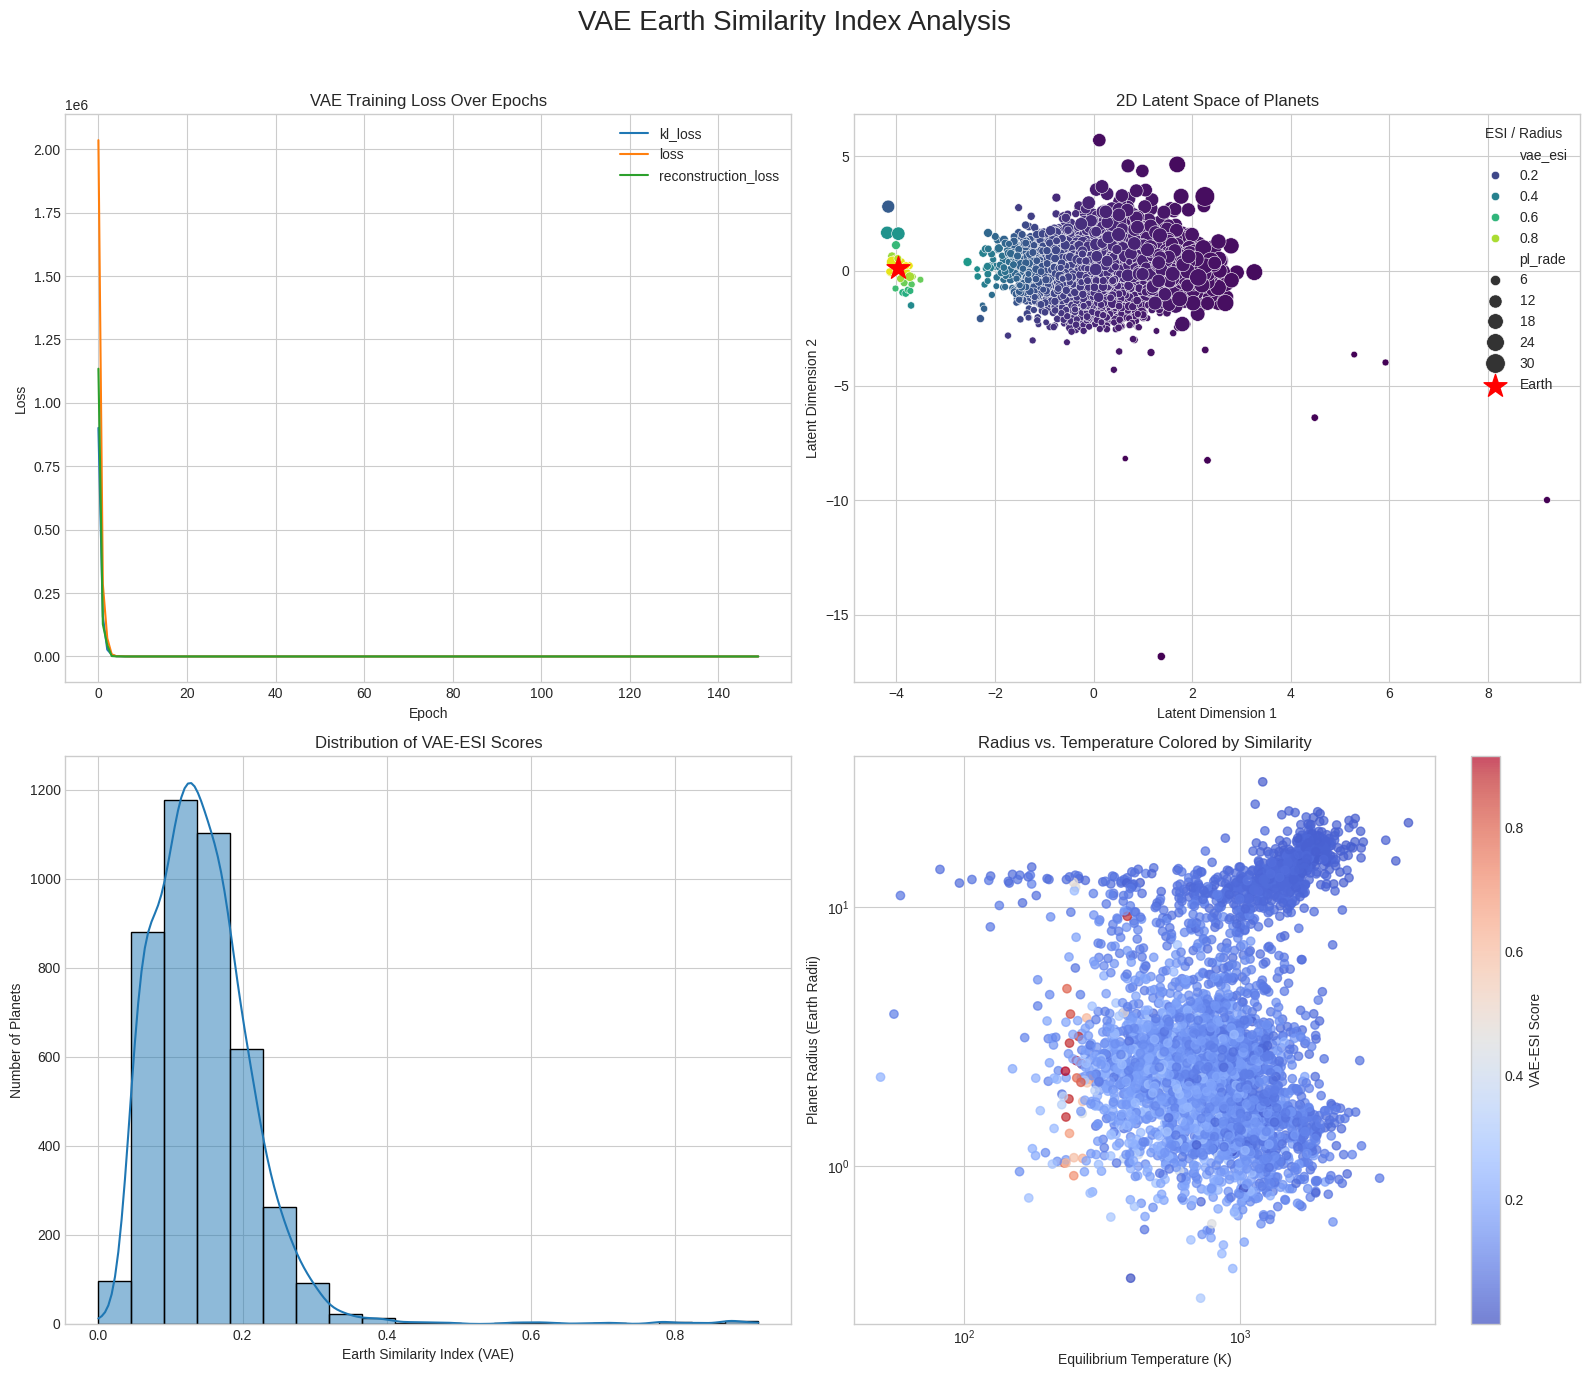

In [82]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('VAE Earth Similarity Index Analysis', fontsize=20)

loss_history = pd.DataFrame(history.history)
loss_history.plot(ax=axes[0, 0], title='VAE Training Loss Over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

sns.scatterplot(data=results_df, x='latent_x', y='latent_y', hue='vae_esi', size='pl_rade',
                sizes=(20, 200), palette='viridis', ax=axes[0, 1])
axes[0, 1].scatter(earth_embedding[0, 0], earth_embedding[0, 1], marker='*', s=300, c='red', label='Earth')
axes[0, 1].set_title('2D Latent Space of Planets')
axes[0, 1].set_xlabel('Latent Dimension 1')
axes[0, 1].set_ylabel('Latent Dimension 2')
axes[0, 1].legend(title='ESI / Radius')

sns.histplot(data=results_df, x='vae_esi', kde=True, bins=20, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of VAE-ESI Scores')
axes[1, 0].set_xlabel('Earth Similarity Index (VAE)')
axes[1, 0].set_ylabel('Number of Planets')

scatter = axes[1, 1].scatter(results_df['pl_eqt'], results_df['pl_rade'], c=results_df['vae_esi'],
                             cmap='coolwarm', alpha=0.7)
fig.colorbar(scatter, ax=axes[1, 1], label='VAE-ESI Score')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Radius vs. Temperature Colored by Similarity')
axes[1, 1].set_xlabel('Equilibrium Temperature (K)')
axes[1, 1].set_ylabel('Planet Radius (Earth Radii)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()